In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from astropy.io import ascii
import wandb
import os
from matplotlib import rcParams

In [2]:
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]
all_stars_in_selected_stars = all_stars_in_selected_stars[~np.isnan(all_stars_in_selected_stars["rrmscdpp06p0"])]


In [19]:
import glob

x = torch.zeros((0,7))
y = torch.zeros((0,11))

for i in glob.glob("simulations_etazero/data_x*"):
    run_label = i[34:]
    xnew = torch.load(i)
    ynew = torch.load("simulations_etazero/data_y_mult_hist_"+run_label)
    x = torch.concatenate((x,xnew),dim=0)
    y = torch.concatenate((y,ynew),dim=0)


#torch.save(x,"all_sims_x")
#torch.save(y,"all_sims_y")

print(x.shape)
valid_indices = torch.where(torch.sum(y,dim=1)>=108013)
invalid_indices = torch.where(torch.sum(y,dim=1)<108013)

x_invalid = x[invalid_indices]

x = x[valid_indices]
y = y[valid_indices]

print(x.shape)

torch.Size([6942, 7])
torch.Size([2049, 7])


In [ ]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))
N = np.sum(observation)
observation = torch.Tensor(observation)

shuffle_mask = torch.randperm(x.size()[0])
x=x[shuffle_mask]
y=y[shuffle_mask]

torch.sum(y[0],dim=0)

tensor(108014.)

In [ ]:

class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()

        self.fc1 = nn.Linear(6, 64)     
        self.fc2 = nn.Linear(64, 128)  
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)   
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 11)
                             
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.log_softmax = nn.LogSoftmax()

    def forward(self, x):
        
        x = self.relu(self.fc1(x))      
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)      
        x = self.relu(self.fc3(x) )
        x = self.dropout(x)
        x = self.relu(self.fc4(x) )
        x = self.dropout(x)
        x = self.relu(self.fc5(x) )
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.log_softmax(self.fc7(x))        

        return x



model = Emulator()

learning_rate = 0.0005
num_epochs = 5000
batch_size = 16
train_percent = 0.8
train_size = int(len(x)*train_percent)
step_size = 100

def criterion(output,target):
    return -torch.sum((target*output),dim=1)
    
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,step_size)

norm_factor = (torch.max(x,dim=0)[0])

inputs = x[:train_size,:-1]/norm_factor[:-1]
targets = y[:train_size]

inputs_val = x[train_size:,:-1]/norm_factor[:-1]
targets_val = y[train_size:]

dataset = torch.utils.data.TensorDataset(inputs, targets)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(inputs_val, targets_val)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)




In [23]:
training_index = f"batch_size_{batch_size}_lr_{learning_rate}_datasize_{x.shape[0]}"

os.environ["WANDB_NOTEBOOK_NAME"] = "planet-sim-emulator.ipynb"

wandb.init(
    project="kepler pop",  
    name=training_index,         
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "datasize": x.shape[0],
        "scheduler_step_size": step_size,
        "train_percentage": train_percent}
)


In [ ]:
train_losses = []
val_losses = []
min_val_loss = 10000000


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_inputs, batch_targets in data_loader:
    
        outputs = model(batch_inputs)
            
        loss = torch.mean(criterion(outputs, batch_targets),dim=0)

        optimizer.zero_grad() 
        loss.backward()     
        optimizer.step()       
 
        running_loss  += loss.item()
        scheduler.step()

    running_loss_val  = 0.0

    with torch.no_grad():
        model.eval()
        for batch_inputs, batch_targets in data_loader_val:
            
            outputs = model(batch_inputs)
            loss = torch.mean(criterion(outputs, batch_targets),dim=0)
            running_loss_val  += loss.item()


    train_losses.append(running_loss / len(data_loader))
    val_losses.append(running_loss_val / len(data_loader_val))

    wandb.log({"train": {"loss":np.average(np.array(train_losses))}, "val": {"loss": np.average(np.array(val_losses))}})

    if running_loss_val / len(data_loader_val) < min_val_loss :
        min_val_loss  = running_loss_val / len(data_loader_val)
        best_model  = model
        torch.save(best_model .state_dict(), "best_model_0to10")
    # Print loss for each epoch
    
    avg_loss = running_loss  / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs }], Loss: {avg_loss:.4f}")


print("Training complete!")
wandb.finish()

Epoch [1/5000], Loss: 92785.2645
Epoch [2/5000], Loss: 38509.9384
Epoch [3/5000], Loss: 27606.5494
Epoch [4/5000], Loss: 27047.5314
Epoch [5/5000], Loss: 26575.1687
Epoch [6/5000], Loss: 26255.1822
Epoch [7/5000], Loss: 26052.9068
Epoch [8/5000], Loss: 25879.4782
Epoch [9/5000], Loss: 25763.3111
Epoch [10/5000], Loss: 25588.1127
Epoch [11/5000], Loss: 25489.8347
Epoch [12/5000], Loss: 25384.1966
Epoch [13/5000], Loss: 25273.0528
Epoch [14/5000], Loss: 25285.4845
Epoch [15/5000], Loss: 25088.0397
Epoch [16/5000], Loss: 25046.7529
Epoch [17/5000], Loss: 25047.0564
Epoch [18/5000], Loss: 24955.3558
Epoch [19/5000], Loss: 24839.0436
Epoch [20/5000], Loss: 24866.8747
Epoch [21/5000], Loss: 24786.1083
Epoch [22/5000], Loss: 24754.8223
Epoch [23/5000], Loss: 24726.4375
Epoch [24/5000], Loss: 24617.2009
Epoch [25/5000], Loss: 24559.5938
Epoch [26/5000], Loss: 24566.8298
Epoch [27/5000], Loss: 24599.8870
Epoch [28/5000], Loss: 24503.1571
Epoch [29/5000], Loss: 24493.5775
Epoch [30/5000], Loss: 

Text(0.5, 0, 'epoch')

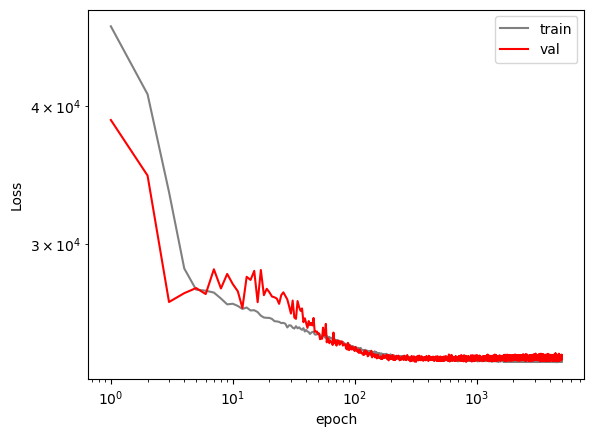

In [9]:

plt.figure()

plt.loglog(range(1,num_epochs),train_losses[1:],color="gray",label="train")
plt.loglog(range(1,num_epochs),val_losses[1:],color="red",label="val")

plt.legend()
plt.ylabel("Loss")
plt.xlabel("epoch")


C:\Users\vtard\AppData\Local\Temp\ipykernel_4356\1471562549.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i].set_ylim(bottom=-1/np.log(10)-0.5,top=500000)


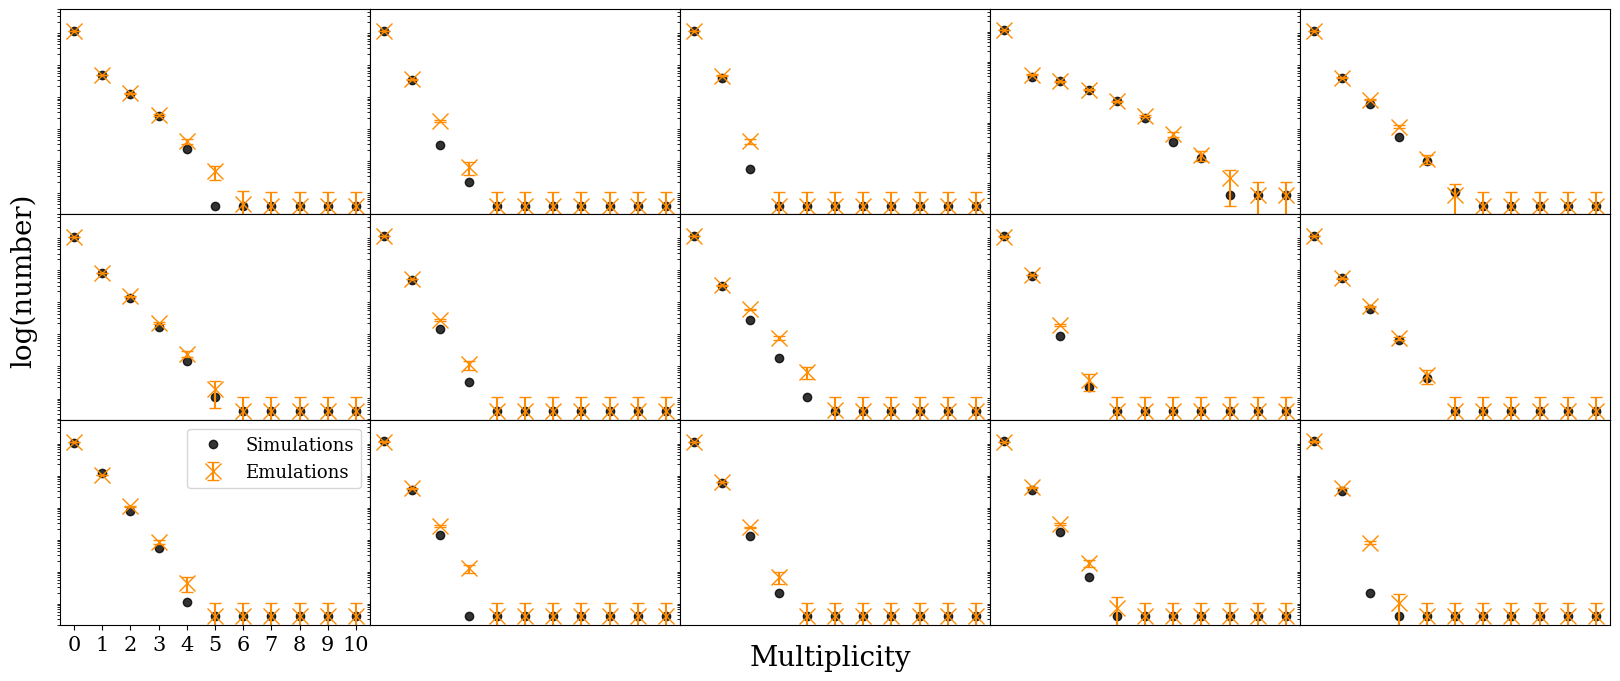

In [ ]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{cmunitx}'  

model.eval()
model.load_state_dict(torch.load("best_model_0to10", weights_only=True))

simulated = targets_val
simulated[simulated==0.0] = 1/(np.e)
emulated = np.exp(model(inputs_val).detach().numpy())*N
emulated[emulated<1/(np.e)] = 1/(np.e)
error_em = emulated**0.5
x_params = inputs_val


fig, axs = plt.subplots(3, 5, figsize=(20, 8), sharex=False, sharey=False)

axs = axs.flatten()

for i in range(15):
    
    axs[i].semilogy(range(0, 11), simulated[i], "o",  markersize = 6,color="black",alpha=0.8,label="Simulations")
    axs[i].errorbar(range(0, 11), emulated[i], yerr = error_em[i],capsize=4,fmt="x", markersize = 12,color="darkorange",label="Emulations")

    axs[i].set_ylim(bottom=-1/np.log(10)-0.5,top=500000)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
   
     
axs[-5].legend(loc="upper right",fontsize=13)
plt.subplots_adjust(wspace=0, hspace=0)
axs[-5].set_xticks(range(0,11),range(0,11),fontsize=15)
#axs[-5].set_yticks([0,2,4],[0,2,4],fontsize=15)
fig.text(0.47,0.06,'Multiplicity',fontsize=20)
fig.text(0.1,0.44,'log(number)',fontsize=20,rotation="vertical")
plt.savefig("sim_vs_em.png")
